In [1]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


download = drive.CreateFile({'id': '1a7y7zC6XIZDjlmH7u5VyYZIffsvqKL3K'})   #paste id here
download.GetContentFile('pickleColor.tar')
!tar -xf pickleColor.tar



    100% |████████████████████████████████| 993kB 20.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive
Archive:  ColorsTesting.zip
   creating: ColorsTesting/
  inflating: ColorsTesting/Y.pickle  
  inflating: ColorsTesting/X.pickle  


In [2]:

import numpy as np
import tensorflow as tf
import random as rn
import os

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)  # 7
rn.seed(12345)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from keras.utils.np_utils import to_categorical
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator


import cv2
import matplotlib.pyplot as plt
%matplotlib inline


X = pickle.load(open("pickle/X.pickle", "rb"))
y = pickle.load(open("pickle/Y.pickle", "rb"))


y = to_categorical(y)

X = np.array(X)
X = X.reshape(17034, 150, 150, 3)

XTEST = pickle.load(open("ColorsTesting/X.pickle", "rb")) #images
YTEST = pickle.load(open("ColorsTesting/Y.pickle","rb"))  #image names
XTEST = np.array(XTEST)
YTEST = np.array(YTEST)
XTEST = XTEST.reshape(7301, 150, 150, 3)

print(X.shape)
print(XTEST.shape)
print(keras.__version__)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=2018)


Using TensorFlow backend.


(17034, 150, 150, 3)
(7301, 150, 150, 3)
2.2.4


In [0]:
pip install h5py

In [0]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

# img_width, img_height = 150, 150
# # train_data_dir = "data/train"
# # validation_data_dir = "data/val"
# nb_train_samples = 4125
# nb_validation_samples = 466 
# batch_size = 16
# epochs = 3

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (150, 150, 3))

# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)

x = Dense(512, activation="relu")(x)
x = Dropout(0.25)(x)

x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)

x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)

predictions = Dense(6, activation="softmax")(x)



# Save the model according to the conditions  
checkpoint = ModelCheckpoint("VGG19.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_acc', min_delta=1, patience=80, verbose=1, mode='max', baseline=0.93) #auto


model = Model(input = model.input, output = predictions)
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])  #0.0001


aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,  #20
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

start = time.time()
history = model.fit_generator(aug.flow(X_train, y_train, batch_size=32),validation_data=(X_test, y_test), steps_per_epoch=np.ceil(X_train.shape[0] / 32),
                              epochs=80, verbose=1,callbacks = [checkpoint, early])
print("Time taken to train: ", (time.time() - start)/60)


#93.69
# x = model.output
# x = Flatten()(x)
# # x = Dense(1024, activation="relu")(x)
# # x = Dropout(0.30)(x)

# x = Dense(512, activation="relu")(x)
# x = Dropout(0.25)(x)

# x = Dense(256, activation="relu")(x)
# x = Dropout(0.25)(x)

# x = Dense(256, activation="relu")(x)
# x = Dropout(0.25)(x)

# x = Dense(128, activation="relu")(x)
# x = Dropout(0.25)(x)

# # x = Dense(64, activation="relu")(x)
# # x = Dropout(0.10)(x)

# predictions = Dense(6, activation="softmax")(x)





#92.4%
# x = model.output
# x = Flatten()(x)
# # x = Dense(1024, activation="relu")(x)
# # x = Dropout(0.30)(x)

# x = Dense(512, activation="relu")(x)
# x = Dropout(0.25)(x)

# x = Dense(256, activation="relu")(x)
# x = Dropout(0.25)(x)

# x = Dense(128, activation="relu")(x)
# x = Dropout(0.20)(x)

# # x = Dense(64, activation="relu")(x)
# # x = Dropout(0.10)(x)

# predictions = Dense(6, activation="softmax")(x)












# creating the final model 
# model_final = Model(input = model.input, output = predictions)

# compile the model 
# model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# # Initiate the train and test generators with data Augumentation 
# train_datagen = ImageDataGenerator(
# rescale = 1./255,
# horizontal_flip = True,
# fill_mode = "nearest",
# zoom_range = 0.3,
# width_shift_range = 0.3,
# height_shift_range=0.3,
# rotation_range=30)

# test_datagen = ImageDataGenerator(
# rescale = 1./255,
# horizontal_flip = True,
# fill_mode = "nearest",
# zoom_range = 0.3,
# width_shift_range = 0.3,
# height_shift_range=0.3,
# rotation_range=30)

# train_generator = train_datagen.flow_from_directory(
# X_train,
# target_size = (img_height, img_width),
# batch_size = batch_size, 
# class_mode = "categorical")

# validation_generator = test_datagen.flow_from_directory(
# y_train,
# target_size = (img_height, img_width),
# class_mode = "categorical")

# # Save the model according to the conditions  
# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')







Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Instructions for updating:
Use tf.cast instead.
Epoch 1/80
480/480 [==============================] - 246s 512ms/step - loss: 1.5925 - acc: 0.3838 - val_loss: 1.1414 - val_acc: 0.5757

Epoch 00001: val_acc improved from -inf to 0.57570, saving model to VGG19.h5
Epoch 2/80
480/480 [==============================] - 236s 491ms/step - loss: 1.1873 - acc: 0.5625 - val_loss: 1.0624 - val_acc: 0.5751

Epoch 00002: val_acc did not improve from 0.57570
Epoch 3/80
480/480 [==============================] - 235s 490ms/step - loss: 1.0743 - acc: 0.5885 - val_loss: 0.9785 - val_acc: 0.5957

Epoch 00003: val_acc improved from 0.57570 to 0.59566, saving model to VGG19.h5
Epoch 4/80
480/480 [==============================] - 235s 490ms/step - loss: 0.9986 - acc: 0.6075 - val_loss: 0.9051 - val_acc: 0.6127

Epoch 00004: val_acc improved from 0.59566 to 0.61268, saving model to VGG19.h5
Epoch 5/80
480/480 [==============================] - 236s 491ms/step - loss: 0.9407 - acc: 0.6186 - val_loss: 0.8405

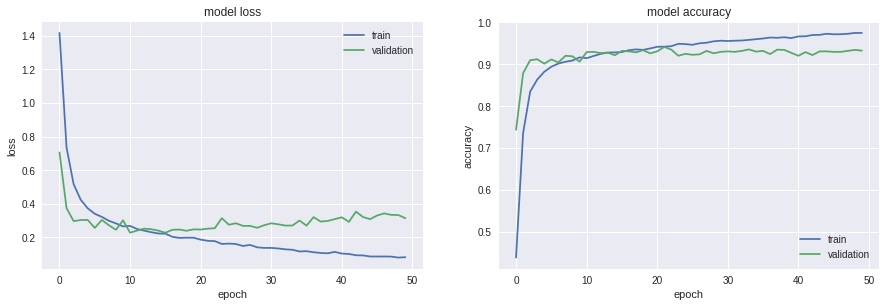

In [0]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()